In [1]:
import json
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import statsmodels.tsa.stattools as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import statsmodels.api as sma

%config IPCompleter.greedy=True
pd.set_option('display.max_rows', 50)

#Definimos la funcion para importar el JSON con los datos de las ventas
def import_data():
    with open("fishVigo.json") as file:
        dataset = pd.read_json(file)
        return dataset

#Asignamos el resultado de la funcion a una variable y lo convertimos a DataFrame
df = pd.DataFrame(import_data())
df.date = pd.to_datetime(df.date)

#Seteamos un indice basado en la fecha y la especie y eliminamos las filas duplicadas quedandonos con la primera de ellas
df = df.set_index(['date','name'])
df = df[~df.index.duplicated(keep = 'first')]

#Convertimos la columna de cantidades a numerico
df['quantity'] = df['quantity'].str.replace('Kg.','')
df['quantity'] = df['quantity'].str.replace('.','')
df['quantity'] = df['quantity'].str.replace(',','.')
df['quantity'] = pd.to_numeric(df['quantity'])
df = df['quantity']

#Mediante reshape creamos registros a 0. Ahora para todos los días tenemos datos de todas las especies
df = df.unstack().fillna(0).stack()
df.head

<bound method NDFrame.head of date        name               
2017-02-01  ABADEJO                 42.4
            ACEDIA-GOLLETAS          0.0
            ACEDIAS                  1.6
            AGUJAS                   0.0
            ALACHA                 310.0
                                   ...  
2019-09-09  VARIADO                 52.0
            VIEIRAS                  0.0
            VIEJAS                   0.0
            VOLADOR- POTA-POTON    125.0
            XOUBA                    0.0
Length: 172430, dtype: float64>

In [2]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = sm.adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [3]:
#Sacamos el porcentaje de cuanto ha aportado al total de capturas cada especie
total = df.sum()
groupName = df.groupby('name').sum()
percentage = groupName/total*100
top = 5

#Seleccionamos aquellas especies cuyo aporte a las capturas supone mas del 5%
percentage = pd.DataFrame(percentage[percentage>top])
selectedSpecies = list(percentage.index.unique())
percentage.columns = ['quantity']
percentage = percentage.reset_index()

#Dibujamos
bar = go.Figure(go.Bar(x = percentage.name, y = percentage.quantity))
bar = bar.update_layout(title='Top '+str(top)+' Cuota',yaxis_title="% Porcentaje")
bar.show()

In [4]:
#Extraemos del df aquellos datos pertenecientes a las especies seleccionadas
for x in selectedSpecies:
    dfTop = df.xs(x, level=1, drop_level=False)
    
    dfTop = pd.DataFrame(dfTop)
    
    dfTop.columns = ['quantity']
    dfTop = dfTop.reset_index()
    
    fig = go.Figure(data = go.Scatter(x=dfTop.date, y=dfTop.quantity),
                                        layout_title_text = x)
    fig.show()

In [5]:
for x in selectedSpecies:
    df1 = df.xs(x, level=1, drop_level=False)

    sTest = StationarityTests()
    sTest.ADF_Stationarity_Test(df1, printResults = True)
    print("Is the time series " + x + " stationary? {0}".format(sTest.isStationary))


Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.804280
P-Value                   0.057665
# Lags Used              21.000000
# Observations Used     780.000000
Critical Value (1%)      -3.438761
Critical Value (5%)      -2.865253
Critical Value (10%)     -2.568747
dtype: float64
Is the time series CABALON-ESTORNINO stationary? False
Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.834992
P-Value                   0.002569
# Lags Used              11.000000
# Observations Used     790.000000
Critical Value (1%)      -3.438655
Critical Value (5%)      -2.865205
Critical Value (10%)     -2.568722
dtype: float64
Is the time series GALLO stationary? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.743722
P-Value                   0.000070
# Lags Used              11.000000
# Observations Used     790.000000
Critical Value (1%)      -3.438655
Critical Value (5%)      -2.865205
Critical Value (10%)     -2.568722
dtype: float64
Is the ti

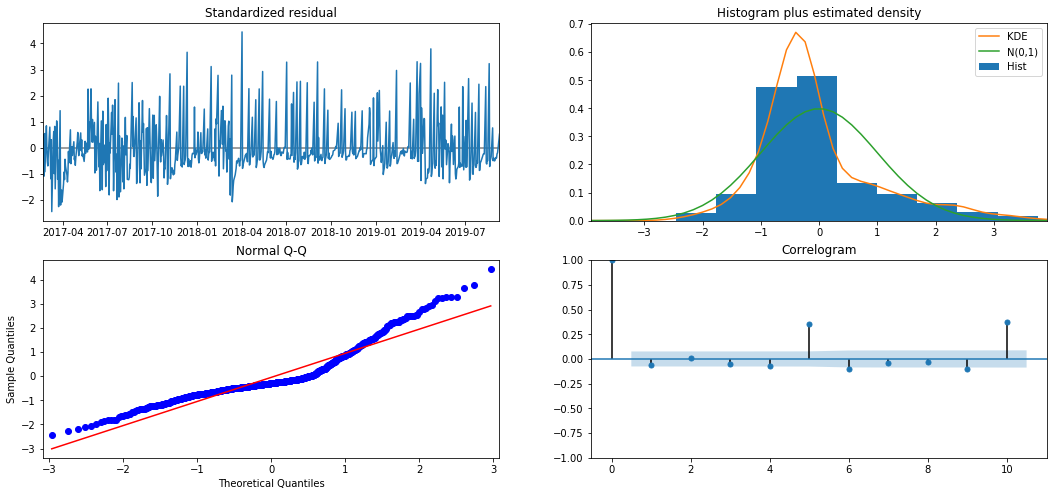

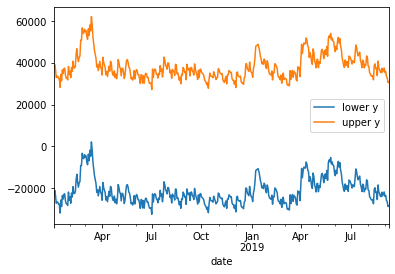

In [6]:
dfPredict = df.xs('GALLO', level=1, drop_level=True)

dfPredict = dfPredict.asfreq('B',)

dfPredict[dfPredict.isnull()==True] = 0

model = sma.tsa.statespace.SARIMAX(dfPredict, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
results = model.fit()
#plot = results.plot(500, 600)
results.plot_diagnostics(figsize=(18, 8))

#model.geterrors()

pred = results.get_prediction(start=pd.to_datetime('2018-01-03'), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.plot()

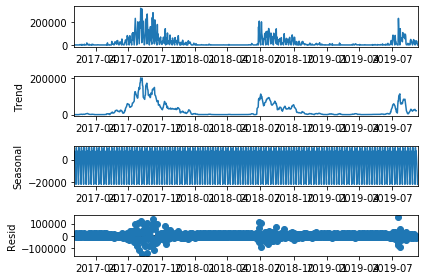

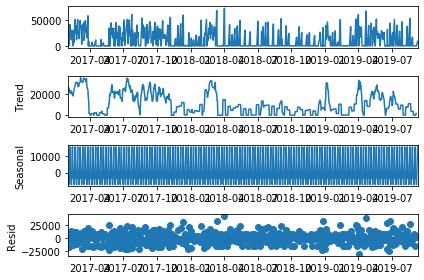

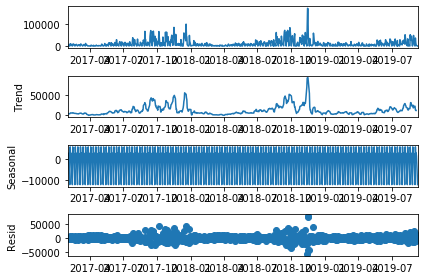

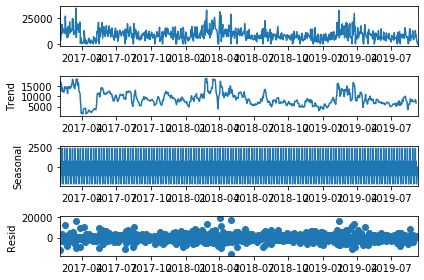

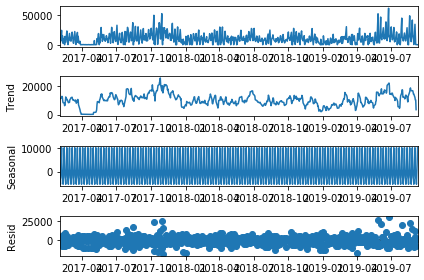

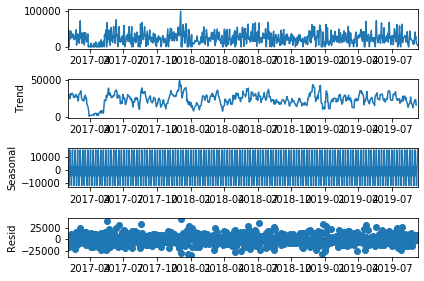

In [7]:
for x in selectedSpecies:
    y = "./plots/test" + x + "png"
    
    dfDecomp = df.xs(x, level=1, drop_level=True)
    dfDecomp = dfDecomp.asfreq('B',)
    
    dfDecomp[dfDecomp.isnull()==True] = 0
    
    result = seasonal_decompose(dfDecomp, model='additive')
    fig = result.plot()
    fig.savefig(y,dpi=500)

In [8]:
dfARIMA = df.xs('RAPE-SAPO', level=1, drop_level=True)
dfARIMA = dfARIMA.asfreq('B',)

dfARIMA[dfARIMA.isnull()==True] = 0

stepwise_model = auto_arima(dfARIMA, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=5,
                           start_P=0, seasonal=True,
                           d=None, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
#print(stepwise_model.aic())
result = stepwise_model.fit(dfARIMA)

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 5) (constant=True); AIC=15043.619, BIC=15057.181, Time=0.049 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 5) (constant=True); AIC=15115.449, BIC=15124.490, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 5) (constant=True); AIC=15066.180, BIC=15084.263, Time=0.123 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 5) (constant=True); AIC=15044.676, BIC=15062.758, Time=0.078 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 5) (constant=False); AIC=15876.833, BIC=15881.353, Time=0.007 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 5) (constant=True); AIC=15119.634, BIC=15137.716, Time=0.763 seconds
Near non-invertible roots for order (0, 0, 0)(1, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 0, 2, 5) (constant=True); AIC=15004.514, BIC=15022.597, Time=0.157 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 2, 5) (constant=True); AIC=15005.103, BIC=15027.706, Time=0.466 second